### 0 : IMPORTING LIBRARIES

In [43]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
import pytorch_lightning as pl
from typing import Tuple
import PIL
from PIL import Image
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import csv
from torchmetrics.functional import accuracy
import numpy as np
import torchvision
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import cv2
from torchvision import datasets
from torchmetrics.classification import Accuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from pytorch_lightning.callbacks import TQDMProgressBar, LearningRateMonitor, ModelCheckpoint


### 1: SEED SETTING AND DATASET ANALYSIS \& ANALYSIS

#### 1.1: SEED SETTING

In [44]:
# Fixing random state for reproducibility using NumPy
rng = np.random.RandomState(31)

# Setting the seed for NumPy to ensure reproducibility
np.random.seed(31)

# Setting the seed for PyTorch Lightning to ensure reproducibility
pl.seed_everything(31)

#torch.manual_seed(31)
#torch.cuda.manual_seed(31)
#torch.backends.cudnn.deterministic = True

31

#### 1.2: DATASET INSPECTION

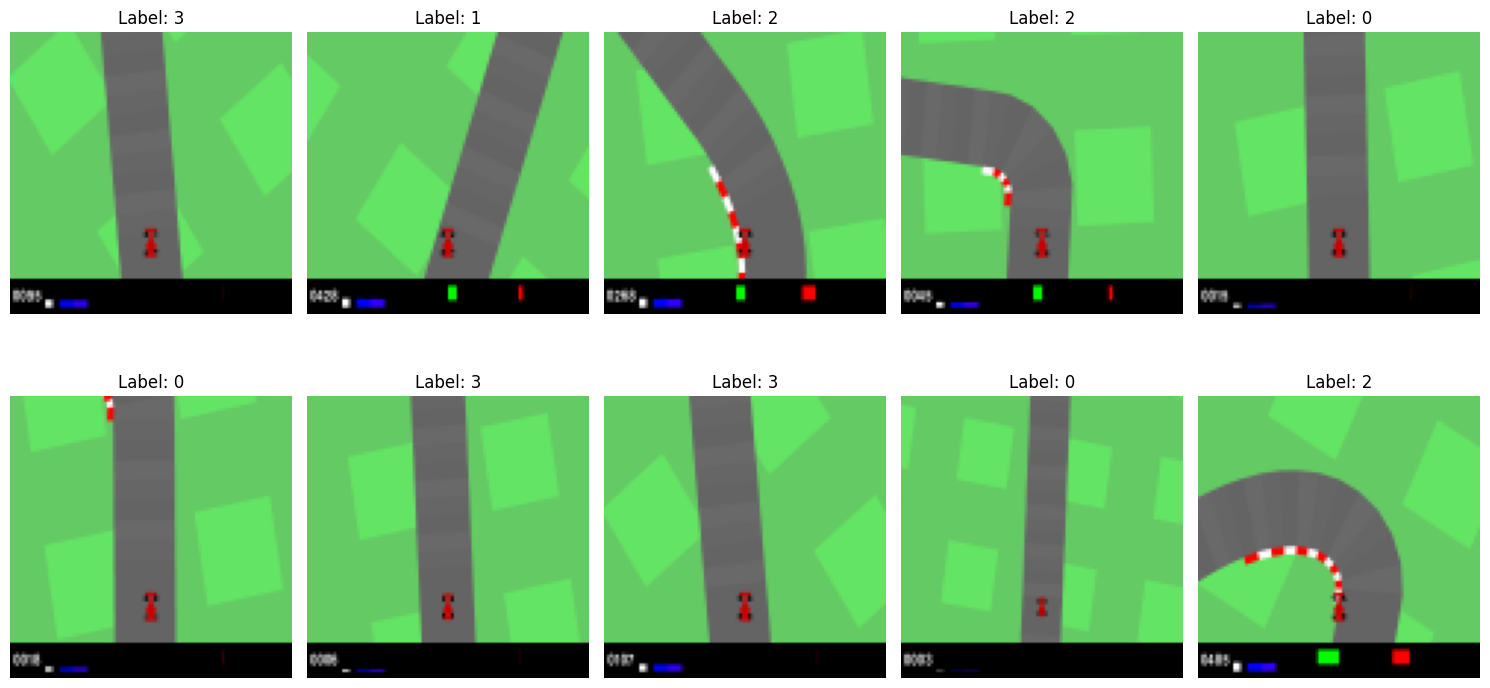

In [45]:
# Assuming you have already loaded the dataset using ImageFolder
dataset0 = datasets.ImageFolder(root="/kaggle/input/hw2-train/train", transform=None)

# Extract class names and their counts
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Create a grid of 10 images with labels
plt.figure(figsize=(15, 8))
for i in range(10):
    # Randomly select an image and its corresponding label
    index = np.random.randint(len(dataset0))
    image, label = dataset0[index]

    # Display the image with its label
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 1.3: Displaying the Cropping Pre-Processing

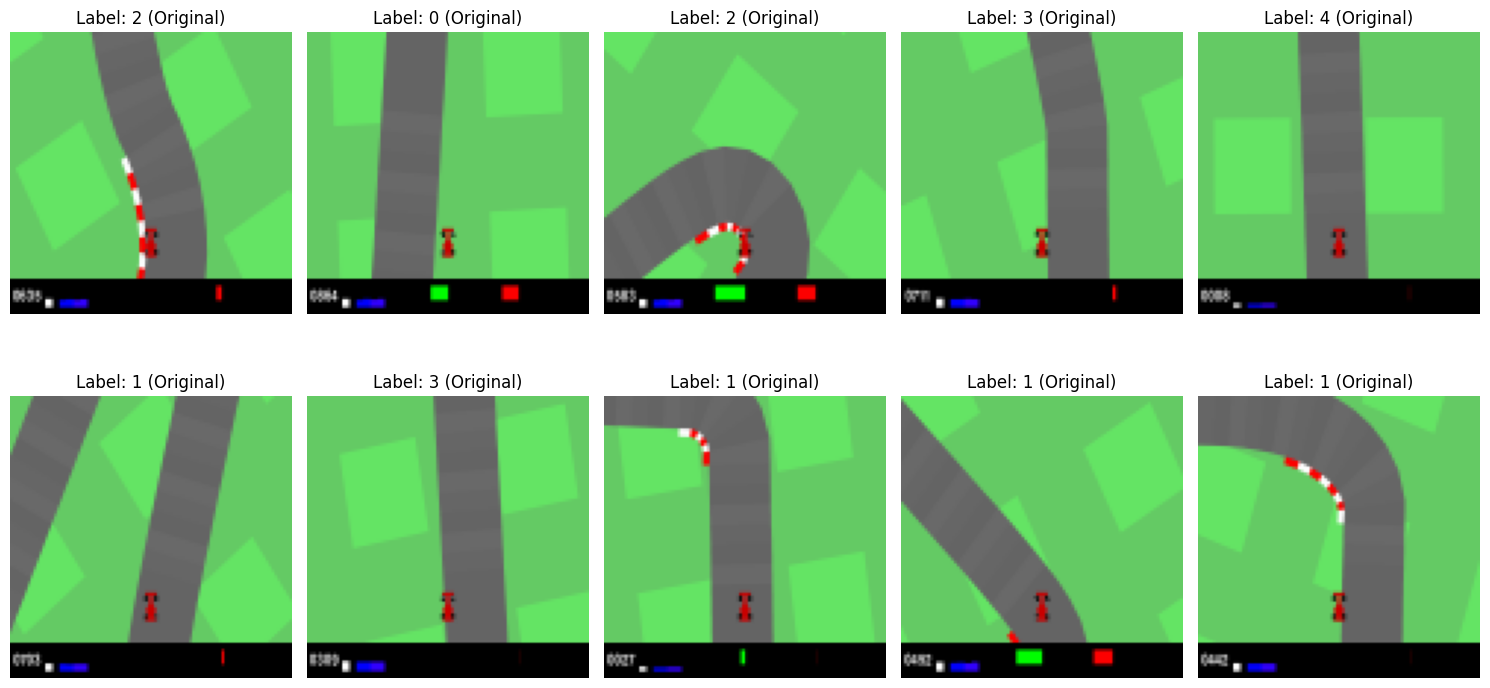

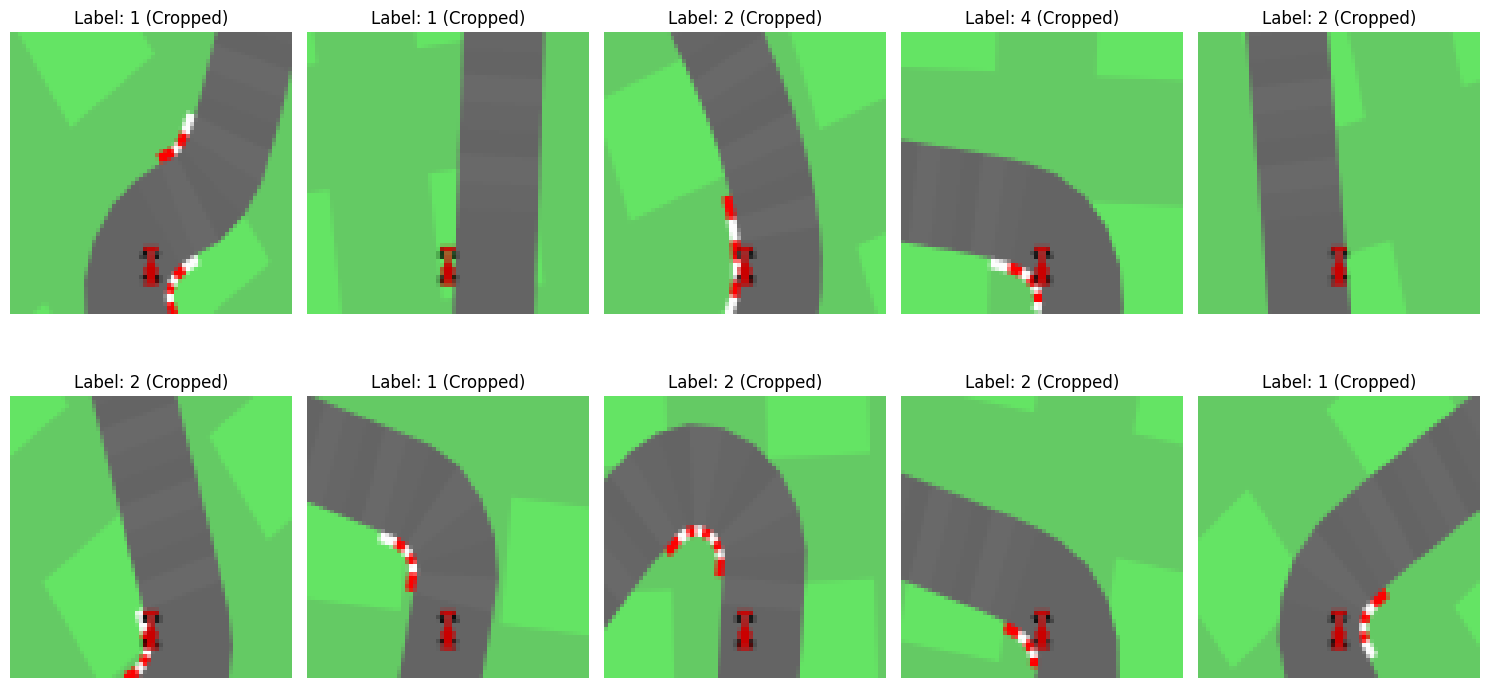

In [46]:
# Assuming you have already loaded the dataset using ImageFolder
dataset0 = datasets.ImageFolder(root="/kaggle/input/hw2-train/train", transform=None)

# Extract class names and their counts
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Create a grid of 10 images with labels
plt.figure(figsize=(15, 8))
for i in range(10):
    # Randomly select an image and its corresponding label
    index = np.random.randint(len(dataset0))
    image, label = dataset0[index]

    # Display the original image with its label
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {class_names[label]} (Original)")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Create a grid of 10 cropped images with labels
plt.figure(figsize=(15, 8))
for i in range(10):
    # Randomly select an image and its corresponding label
    index = np.random.randint(len(dataset0))
    image, label = dataset0[index]

    # Crop the image by 10 pixels on all borders
    cropped_image = image.crop((12, 12, image.width - 12, image.height - 12))
    # Display the cropped image with its label
    plt.subplot(2, 5, i+1)
    plt.imshow(np.array(cropped_image))  # Convert the PIL Image to a numpy array
    plt.title(f"Label: {class_names[label]} (Cropped)")
    plt.axis('off')

plt.tight_layout()
plt.show()


#### 1.2: CLASS DISTRIBUTION 

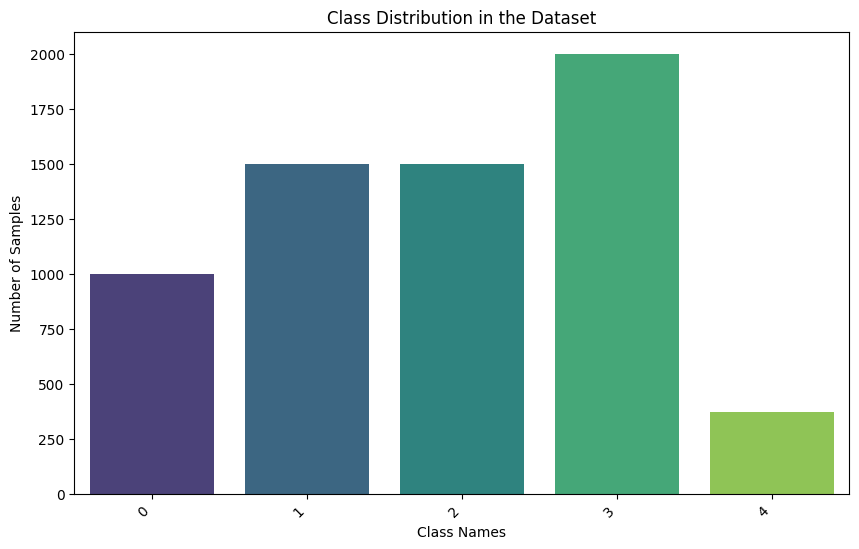

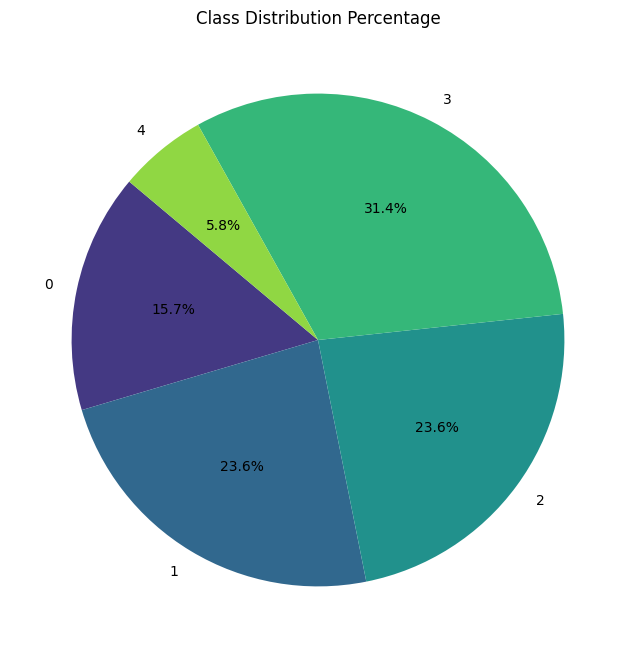

In [47]:
# Loading the dataset using ImageFolder.
dataset0 = datasets.ImageFolder(root="/kaggle/input/hw2-train/train", transform=None)

# Extract class names and their counts.
class_names = dataset0.classes
class_counts = [dataset0.targets.count(i) for i in range(len(class_names))]

# Plot a bar graph to show class distribution.
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Class Distribution in the Dataset")
plt.xlabel("Class Names")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.show()

# Show a pie chart for a clearer representation of proportions.
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(class_names)))
plt.title("Class Distribution Percentage")
plt.show()

In [48]:
# Set the class weights to be used in the Training Process
class_weights = [0.157, 0.236, 0.236, 0.314, 0.058]
class_weights = torch.FloatTensor(class_weights)

### 2: DATA MODULE DEFINITION

In [49]:
class HW2_DataModule(pl.LightningDataModule): 
    def __init__(self, train_data_dir, test_data_dir, batch_size, num_workers=4, val_split=0.2):
        
        super(HW2_DataModule, self).__init__()
        self.train_data_dir = train_data_dir
        self.test_data_dir = test_data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        
        self.transform = transforms.Compose([
            transforms.Lambda(lambda x: x.crop((12, 12, x.width - 12, x.height - 12))),
            transforms.ToTensor()
        ])

    def setup(self, stage=None):
        # Load train and validation datasets
        dataset = ImageFolder(self.train_data_dir, transform=self.transform)

        # Split the dataset into training and validation sets
        train_size = int((1.0 - self.val_split) * len(dataset))
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

        # Load the test dataset with preprocessing
        self.test_dataset = ImageFolder(self.test_data_dir, transform=self.transform)

    def train_dataloader(self):
        
        # Return the DataLoader for the training dataset
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle = True)

    def val_dataloader(self):
        
        # Return the DataLoader for the validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
    
    def test_dataloader(self):
        # Return the DataLoader for the test dataset
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    

### 3: MODEL DEFINITION

#### 3.1: CNN DEFINITION

In [50]:
class CNN_Model(nn.Module):
    def __init__(self, input_channels, num_classes):
        
        # Definition of the CNN Model
        super(CNN_Model, self).__init__()
        
        # 4 Conv-Layers: 2 x Relu(Average Pooling(x))  +    2 x Relu(Max Pooling(x))
        self.relu = nn.ReLU()        
        self.conv1 = nn.Conv2d(input_channels, 24, 3, 1)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(24, 32, 3, 1)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 48, 3, 1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3 Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2352, 784)
        self.fc2 = nn.Linear(784, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        # Initialize the weights using the Xavier-Uniform Initialization.
        self._initialize_weights()

    def forward(self, x):    
    
        # Definition of the forward function
        #print(f"Input shape: {x.shape}")

        x = self.avgpool1(self.relu(self.conv1(x)))
        #print(f"After conv1 and avgpool1: {x.shape}")

        x = self.avgpool2(self.relu(self.conv2(x)))
        #print(f"After conv2 and avgpool2: {x.shape}")

        x = self.maxpool3(self.relu(self.conv3(x)))
        #print(f"After conv3 and maxpool3: {x.shape}")
        
        x = self.relu(self.fc1(self.flatten(x)))
        #print(f"After fc1 and flatten: {x.shape}")
        
        x = self.relu(self.fc2(x))
        #print(f"After fc2 and flatten: {x.shape}")
        
        x = self.fc3(x)
        #print(f"After fc3: {x.shape}")

        # Returning the Log Softmax. 
        return self.log_softmax(x)

    
    def _initialize_weights(self):
        
        # Weight Initialization using the Xavier-Uniform Initialization.
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


#### 3.2: HW2 GENERAL MODEL 

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()

        if self.reduction == 'mean':
            return focal_loss
        elif self.reduction == 'sum':
            return focal_loss.sum()
        elif self.reduction == 'none':
            return focal_loss
        else:
            raise ValueError("Invalid reduction option. Use 'mean', 'sum', or 'none'.")


In [52]:
class HW2_Model(CNN_Model, pl.LightningModule):
    
    def __init__(self, input_channels, num_classes):
        
        super(HW2_Model, self).__init__(input_channels, num_classes)

        # Definition of the Weighted Cross Entropy Loss + Label Smoothing.
        self.loss = CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
        #self.loss = nn.NLLLoss(weight=class_weights)
        #self.loss = nn.MultiLabelSoftMarginLoss(weight=class_weights)
        self.loss = FocalLoss(gamma=2, alpha=1, reduction='mean')


        # Definition of Accuracy, F1Score, Precision and Recall Metrics.
        self.acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.f1score = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.precision = MulticlassPrecision(num_classes=num_classes, average='macro')
        self.recall = MulticlassRecall(num_classes=num_classes, average='macro')
        
        # Definition of lists to be used in the "on_ ... _epoch_end" functions.
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
    
    def predict(self, obs):
        # Assuming obs is a NumPy array with shape (96, 96, 3)

        # Define a custom lambda function for cropping
        crop_function = transforms.Lambda(lambda x: x[12:-12, 12:-12, :])

        # Apply cropping and convert the observation to a PyTorch tensor.
        obs_tensor = transforms.Compose([crop_function, transforms.ToTensor()])(obs)

        # Add a batch dimension to the observation.
        obs_tensor = obs_tensor.unsqueeze(0)

        # Ensure the model is in evaluation mode.
        self.eval()

        # Forward pass to get predictions.
        with torch.no_grad():
            preds = self(obs_tensor)

        # Get the predicted class labels.
        predicted_labels = torch.argmax(preds, dim=1).cpu().numpy()

        return predicted_labels

    
    def _step(self, batch):
        
        # Common computation of the metrics among Training, Validation and Test Set.
        x, y = batch
        preds = self(x)
        loss = self.loss(preds, y)
        acc = self.acc(preds, y)
        f1score = self.f1score(preds, y)
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)
        
        return loss, acc, f1score, precision, recall
    
    
    def training_step(self, batch, batch_idx):
        
        # Compute the Training Loss and Accracy.
        loss, acc, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the training step.
        training_step_output = {
            "train_loss": loss.item(),
            "train_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.training_step_outputs.append(training_step_output)

        # Perform logging.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        
        # Compute the Validation Loss and Accuracy.
        loss, acc, _, _, _ = self._step(batch)

        # Create a dictionary to represent the output of the validation step.
        validation_step_output = {
            "val_loss": loss.item(),
            "val_acc": acc.item()
        }

        # Append the dictionary to the list.
        self.validation_step_outputs.append(validation_step_output)

        # Perform logging.
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        
        # Calculate the Mean Loss and Accuracy from the list of dictionaries.
        loss_tot = torch.tensor([item["val_loss"] for item in self.validation_step_outputs]).mean()
        acc_tot = torch.tensor([item["val_acc"] for item in self.validation_step_outputs]).mean()

        # Log the mean values.
        self.log("val_loss", loss_tot)
        self.log("val_acc", acc_tot)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Validation Loss -> {loss_tot}'
        message_accuracy = f'      Validation Accuracy -> {acc_tot}'
        print(message_loss + message_accuracy)

        # Clear the list to free memory.
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        
        # Compute the Validation Loss, Accuracy, F1Score, Precision and Recall.
        loss, acc, f1score, precision, recall = self._step(batch)

        # Create a dictionary to represent the output of the test step.
        test_step_output = {
            "test_loss": loss.item(),
            "test_acc": acc.item(),
            "f1score": f1score.item(),
            "precision": precision.item(),
            "recall": recall.item()
        }

        # Append the dictionary to the list.
        self.test_step_outputs.append(test_step_output)

        # Perform logging.
        self.log("test_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_f1score", f1score, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_precision", precision, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_recall", recall, on_epoch=True, prog_bar=True, logger=True)

    def on_test_epoch_end(self):
        
        # Calculate the mean loss, accuracy, f1score, precision and recall from the list of dictionaries.
        loss_tot = torch.tensor([item["test_loss"] for item in self.test_step_outputs]).mean()
        acc_tot = torch.tensor([item["test_acc"] for item in self.test_step_outputs]).mean()
        f1score_tot = torch.tensor([item["f1score"] for item in self.test_step_outputs]).mean()
        precision_tot = torch.tensor([item["precision"] for item in self.test_step_outputs]).mean()
        recall_tot = torch.tensor([item["recall"] for item in self.test_step_outputs]).mean()

        # Log the mean values.
        self.log("test_loss", loss_tot)
        self.log("test_acc", acc_tot)
        self.log("test_f1score", f1score_tot)
        self.log("test_precision", precision_tot)
        self.log("test_recall", recall_tot)

        # Print messages.
        message_loss = f'Epoch {self.current_epoch} Test Loss -> {loss_tot}'
        message_accuracy = f'      Test Accuracy -> {acc_tot}'
        message_f1score = f'      Test F1 Score -> {f1score_tot}'
        message_precision = f'      Test Precision -> {precision_tot}'
        message_recall = f'      Test Recall -> {recall_tot}'
        print(message_loss + message_accuracy + message_f1score + message_precision + message_recall)

        # Clear the list to free memory.
        self.test_step_outputs.clear()
    
    def configure_optimizers(self):
        
        # Configure the Adam Optimizer.
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        #optimizer = optim.Adagrad(self.parameters(), lr=0.01, lr_decay=0.001)
        #optimizer = optim.RMSprop(self.parameters(), lr=0.001, alpha=0.9, eps=1e-08)
        #optimizer = optim.Adadelta(self.parameters(), lr=1.0, rho=0.9, eps=1e-06)
        #optimizer = optim.Adamax(self.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08)
        return optimizer
        
    def count_params(self):
        
        # Return the number of parameters present in the Model.
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

### 4: MODEL TRAINING

#### 4.1: CUSTOM CALLBACKS DEFINITION

In [53]:
# Checkpoint CallBack Definition.
my_checkpoint_call = ModelCheckpoint(
    dirpath="/kaggle/working/checkpoints/",
    filename="Best_Model",
    monitor="val_loss",
    mode="min",
    save_top_k=1
)

# Learning Rate CallBack Definition.
my_lr_monitor_call = LearningRateMonitor(logging_interval="epoch")

# Early Stopping CallBack Definition.
my_early_stopping_call = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", min_delta=0.001)

# Progress Bar CallBack Definition.
my_progress_bar_call = TQDMProgressBar(refresh_rate=10)

# TensorBoardLogger CallBack Definition.
tb_logger = TensorBoardLogger("/kaggle/working/logs", name="HW2_CNN")

# CSV CallBack Definition.
csv_logger = CSVLogger("/kaggle/working/logs", name="HW2_CNN")


#### 4.2: TRAINER DEFINITION

In [54]:
# Initialize the model and data module.
model = HW2_Model(input_channels=3, num_classes=5)
datamodule = HW2_DataModule(train_data_dir="/kaggle/input/hw2-train/train", test_data_dir="/kaggle/input/hw2-test/test", batch_size=64)

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="auto", 
    devices="auto",
    log_every_n_steps=1,
    logger=tb_logger,
    callbacks=[my_progress_bar_call,
               my_checkpoint_call,
               my_lr_monitor_call,
               my_early_stopping_call,
               ]
)


In [55]:
# Train the model
result = trainer.fit(model, datamodule)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/checkpoints/ exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 1.0530855655670166      Validation Accuracy -> 0.03125


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Loss -> 0.6504179835319519      Validation Accuracy -> 0.5760236978530884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation Loss -> 0.6070379614830017      Validation Accuracy -> 0.5815733075141907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation Loss -> 0.6058871150016785      Validation Accuracy -> 0.6036099195480347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation Loss -> 0.6050243973731995      Validation Accuracy -> 0.5996228456497192


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation Loss -> 0.605272650718689      Validation Accuracy -> 0.6020474433898926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation Loss -> 0.5858885049819946      Validation Accuracy -> 0.6004040837287903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation Loss -> 0.6007794737815857      Validation Accuracy -> 0.6105602979660034


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation Loss -> 0.5735586881637573      Validation Accuracy -> 0.6245420575141907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation Loss -> 0.574557363986969      Validation Accuracy -> 0.6161907315254211


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation Loss -> 0.5836566686630249      Validation Accuracy -> 0.6208782196044922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation Loss -> 0.5604135394096375      Validation Accuracy -> 0.6240032315254211


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation Loss -> 0.5791951417922974      Validation Accuracy -> 0.6270474195480347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation Loss -> 0.5655785202980042      Validation Accuracy -> 0.629795253276825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation Loss -> 0.5842875242233276      Validation Accuracy -> 0.6256465315818787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation Loss -> 0.6162768006324768      Validation Accuracy -> 0.6307920217514038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation Loss -> 0.5778413414955139      Validation Accuracy -> 0.643696129322052


### 5: MODEL TESTING

#### 5.1: BEST-MODEL EXTRAPOLATION

In [56]:
best_model_path = my_checkpoint_call.best_model_path
best_model = HW2_Model.load_from_checkpoint(checkpoint_path=best_model_path, input_channels=3, num_classes=5)

#### 5.2: BEST-MODEL TESTING

In [57]:
# Test the trained model using the testing data from the DataModule.
result = trainer.test(best_model, datamodule)

Testing: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Test Loss -> 0.5877646803855896      Test Accuracy -> 0.635114848613739      Test F1 Score -> 0.3060307502746582      Test Precision -> 0.37369880080223083      Test Recall -> 0.2736700773239136


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.635114848613739     │
│       test_f1score        │    0.3060307502746582     │
│         test_loss         │    0.5877646803855896     │
│      test_precision       │    0.37369880080223083    │
│        test_recall        │    0.2736700773239136     │
└───────────────────────────┴───────────────────────────┘

### 6: BEST-MODEL SAVING

In [58]:
# Specify the path where you want to save the model
model_path = f"/kaggle/working/best_model_acc_{result[0]['test_acc']:.5f}.pth"

# Save the model's state dict to the specified file
torch.save(best_model.state_dict(), model_path)


### 7: BEST-MODEL TESTING (SIMULATOR)

In [59]:
import sys

try:
    import gymnasium as gym
except ModuleNotFoundError:
    print('gymnasium module not found. Try to install with')
    print('pip install gymnasium[box2d]')
    sys.exit(1)


def play(env, model):

    seed = 2000
    obs, _ = env.reset(seed=seed)
    print(obs.shape)
    
    # drop initial frames
    action0 = 0
    for i in range(50):
        obs,_,_,_,_ = env.step(action0)
    
    done = False
    while not done:
        action = model.predict(obs) # adapt to your model
        print(action)
        obs, _, terminated, truncated, _ = env.step(action[0])
        done = terminated or truncated

        done = False

env_arguments = {
    'domain_randomize': False,
    'continuous': False,
    'render_mode': 'human'
}

env_name = 'CarRacing-v2'
env = gym.make(env_name, **env_arguments)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# your trained
# your trained
model = HW2_Model(input_channels=3, num_classes=5) # your trained model
model.load_state_dict(torch.load("./best_model_acc_0.66439.pth"))

play(env, model)



DependencyNotInstalled: Box2D is not installed, run `pip install gymnasium[box2d]`